- Level: Beginner
- Time to complete: 10 minutes
- Components Used: `InMemoryDocumentStore`, `InMemoryBM25Retriever`, `PromptBuilder`, `OpenAIGenerator`
- Prerequisites: You must have an API key from an active OpenAI account as this tutorial is using the gpt-3.5-turbo model by OpenAI.
- Goal: After completing this tutorial, you’ll have learned the new prompt syntax and how to use PromptBuilder and OpenAIGenerator to build a generative question-answering pipeline with retrieval-augmentation.

# Overview

This tutorial shows you how to create a generative question-answering pipeline using the retrieval-augmentation ( RAG) approach with Haystack 2.0.
The process involves three main components: `InMemoryBM25Retriever` for fetching relevant documents, `PromptBuilder` for creating a template prompt, and `OpenAIGenerator` for generating responses.

For this tutorial, you’ll use the Wikipedia pages of Seven Wonders of the Ancient World as Documents, but you can replace them with any text you want.

In [1]:
!pip install "datasets>=2.6.1"

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
from haystack.telemetry import tutorial_running

tutorial_running(27)

# Initializing the DocumentStore

You’ll start creating your question answering system by initializing a DocumentStore.
A `DocumentStore` stores the `Documents` that the question answering system uses to find answers to your questions.
In this tutorial, you’ll be using the `InMemoryDocumentStore`.

In [25]:
from haystack.document_stores.in_memory import InMemoryDocumentStore

document_store = InMemoryDocumentStore()

`InMemoryDocumentStore` is the simplest DocumentStore to get started with.
It requires no external dependencies and it’s a good option for smaller projects and debugging.
But it doesn’t scale up so well to larger Document collections, so it’s not a good choice for production systems. 
To learn more about the different types of external databases that Haystack supports, see DocumentStore Integrations.

The DocumentStore is now ready. Now it’s time to fill it with some Documents.

# Fetching and Writing Documents

You’ll use the Wikipedia pages of Seven Wonders of the Ancient World as Documents.
We preprocessed the data and uploaded to a Hugging Face Space: Seven Wonders.
Thus, you don’t need to perform any additional cleaning or splitting.

Fetch the data and write it to the DocumentStore:

In [26]:
from datasets import load_dataset
from haystack import Document

dataset = load_dataset("bilgeyucel/seven-wonders", split="train")
docs = [Document(content=doc["content"], meta=doc["meta"]) for doc in dataset]
document_store.write_documents(docs)

151

# Initializing the Retriever

Initialize a `InMemoryBM25Retriever` and make it use the `InMemoryDocumentStore` we initialized earlier in this tutorial. 
This Retriever will get the relevant documents to the query:

In [27]:
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever

retriever = InMemoryBM25Retriever(document_store)

# Defining a Template Prompt

Create a custom prompt for a generative question answering task using the RAG approach.
The prompt should take in two parameters
- documents, which are retrieved from a document store
- a question from the user

Use the Jinja2 looping syntax to combine the content of the retrieved documents in the prompt.

Next, initialize a `PromptBuilder` instance with your prompt template.
The `PromptBuilder`, when given the necessary values, will automatically fill in the variable values and generate a complete prompt.
This approach allows for a more tailored and effective question-answering experience.

In [28]:
from haystack.components.builders import PromptBuilder

template = """
Given the following information, answer the question.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
"""

prompt_builder = PromptBuilder(template=template)

# Initializing a Generator

Generators are the components that interacts with large language models (LLMs).
Now, set `OPENAI_API_KEY` environment variable and initialize a OpenAIGenerator that can communicate with OpenAI GPT models.
If you don’t provide any model, the OpenAIGenerator defaults to gpt-3.5-turbo:

In [29]:
import os
from haystack.components.generators import OpenAIGenerator

# Set LLM as OpenAI model
# os.environ["OPENAI_API_KEY"] = ""
# generator = OpenAIGenerator()

# I don't have any OpenAI key, I'm going to use Gemini model
from haystack_integrations.components.generators.google_ai import GoogleAIGeminiGenerator

# os.environ["GOOGLE_API_KEY"] = ""
generator = GoogleAIGeminiGenerator(model="gemini-pro")

You can replace `OpenAIGenerator` in your pipeline with another `Generator`.
Check out the full list of generators [here](https://docs.haystack.deepset.ai/v2.0/docs/generators).

# Building the Pipeline

To build a pipeline, add all components to your pipeline and connect them.
Create connections from `retriever` to the `prompt_builder` and from `prompt_builder` to `llm`.
Explicitly connect the output of `retriever` with "documents" input of the `prompt_builder` to make the connection obvious as `prompt_builder` has two inputs ("documents" and "question"). For more information on pipelines and creating connections, refer to Creating Pipelines documentation.

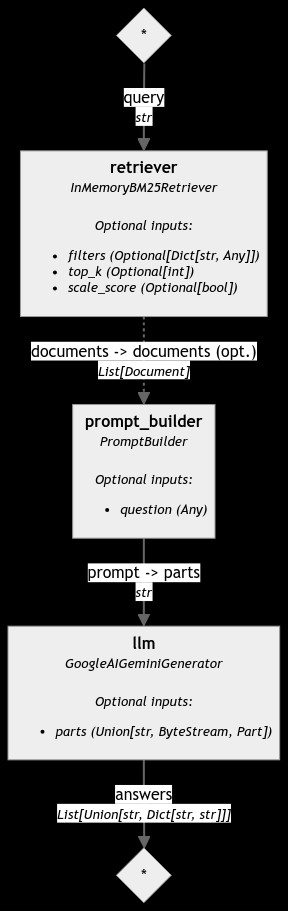

In [30]:
from haystack import Pipeline

basic_rag_pipeline = Pipeline()
# Add components to your pipeline
basic_rag_pipeline.add_component("retriever", retriever)
basic_rag_pipeline.add_component("prompt_builder", prompt_builder)
basic_rag_pipeline.add_component("llm", generator)

# Now, connect the components to each other
basic_rag_pipeline.connect("retriever", "prompt_builder.documents")
basic_rag_pipeline.connect("prompt_builder", "llm")

## Visualize the Pipeline

In [31]:
basic_rag_pipeline.draw("basic-rag-pipeline.png")

# Asking a Question

When asking a question, use the `run()` method of the pipeline.
Make sure to provide the question to both the retriever and the `prompt_builder`.
This ensures that the `{{question}}` variable in the template prompt gets replaced with your specific question.



In [38]:
question = "Where is Gardens of Babylon?"

response = basic_rag_pipeline.run({"retriever": {"query": question}, "prompt_builder": {"question": question}})

print(response["llm"]["answers"])

Ranking by BM25...: 100%|███████████████████████████████████████████████████████| 151/151 [00:00<00:00, 22855.18 docs/s]


['The location of the Gardens of Babylon has not been definitively established. There are three theories:\n\n1. They were purely mythical.\n2. They existed in Babylon but were destroyed sometime around the first century AD.\n3. The legend refers to a well-documented garden that the Assyrian King Sennacherib (704–681 BC) built in his capital city of Nineveh on the River Tigris, near the modern city of Mosul.']


In [39]:
for item in response["llm"]["answers"]:
    print(item)

The location of the Gardens of Babylon has not been definitively established. There are three theories:

1. They were purely mythical.
2. They existed in Babylon but were destroyed sometime around the first century AD.
3. The legend refers to a well-documented garden that the Assyrian King Sennacherib (704–681 BC) built in his capital city of Nineveh on the River Tigris, near the modern city of Mosul.


In [1]:
retriev

NameError: name 'retriev' is not defined